In [32]:
import json
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
from tqdm import tqdm_notebook

from scipy.misc import imread

%matplotlib inline

In [2]:
DATA_FOLDER = 'E:/Data'

In [3]:
train_data = pd.read_csv(DATA_FOLDER + '/validation/train.csv')
bboxes = {}
labels = ['ALB', 'BET', 'DOL', 'LAG', 'SHARK', 'YFT']
files = glob.glob(DATA_FOLDER + '/train/*/*.jpg')
for label in labels:
    with open(DATA_FOLDER + '/labels/{}_labels.json'.format(label.lower())) as f:
        coords = []
        data = json.load(f)
        for image in data:
            for annot in image['annotations']:
                coords.append((os.path.basename(image['filename']), max(0, int(annot['x'])), max(0, int(annot['y'])), int(annot['width']), int(annot['height'])))
        bboxes[label] = coords
        

In [4]:
# maximum number of instances. Prune later
# This is because one image may have multibe bboxes
max_train = sum(len(bboxes[l]) for l in bboxes)
n_labels = len(labels)
X_train = np.zeros((max_train, 3, 128, 128))
y_train = np.zeros((max_train, n_labels))
i = 0
train_files = set(train_data.filename)
for label in tqdm_notebook(bboxes):
    for fname, x, y, width, height in tqdm_notebook(bboxes[label]):
        if fname in train_files:
            img = imread(DATA_FOLDER + '/train/{}/{}'.format(label, fname))
            try:
                img = cv2.resize(img[y:y+width, x:x+width], (128, 128)).transpose(2, 0, 1)
            except:
                print(fname)
            X_train[i] = img
            y_train[i] = np_utils.to_categorical(labels.index(label), n_labels)
            i += 1
            
# Shuffle and prune
perm_idxs = np.random.permutation(i)
X_train = X_train[perm_idxs] / 255
y_train = y_train[perm_idxs]

In [5]:
val_data = pd.read_csv(DATA_FOLDER + '/validation/test.csv')
val_files = set(val_data.filename)
X_val = np.zeros((max_train, 3, 128, 128))
y_val = np.zeros((max_train, n_labels))
i = 0
for label in tqdm_notebook(bboxes):
    for fname, x, y, width, height in tqdm_notebook(bboxes[label]):
        if fname in val_files:
            img = imread(DATA_FOLDER + '/train/{}/{}'.format(label, fname))
            try:
                img = cv2.resize(img[y:y+width, x:x+width], (128, 128)).transpose(2, 0, 1)
            except:
                print(fname)
            X_val[i] = img
            y_val[i] = np_utils.to_categorical(labels.index(label), n_labels)
            i += 1

perm_idxs = np.random.permutation(i)
X_val = X_val[perm_idxs] / 255
y_val = y_val[perm_idxs]

In [28]:
model = Sequential()

model.add(Convolution2D(16, 3, 3, border_mode='same', input_shape=[3, 128, 128], 
                        activation='relu'))
model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_labels, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy', 'categorical_crossentropy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_11 (Convolution2D) (None, 16, 128, 128)  448         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 16, 128, 128)  2320        convolution2d_11[0][0]           
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 16, 64, 64)    0           convolution2d_12[0][0]           
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 16, 64, 64)    0           maxpooling2d_5[0][0]             
___________________________________________________________________________________________

In [29]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=10,
                             zoom_range=[0.8, 1.2],
                             width_shift_range=0.1,
                             height_shift_range=0.1)
train_gen = datagen.flow(X_train, y_train)
val_gen = ImageDataGenerator().flow(X_val, y_val)

In [30]:
csv_logger = CSVLogger('run4_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.9)
checkpoint = ModelCheckpoint(filepath='E:/Models/adam/model.{epoch:02d}-{loss}.hdf5', verbose=1, save_best_only=True)

model.fit_generator(train_gen, samples_per_epoch=len(X_train),
                    nb_epoch=500, verbose=2,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, nb_val_samples=len(X_val))

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/Joris/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.12-64/tmpr3xx55/7e8c9d992dce809a5715c4cc5f96a5bd.lib and object C:/Users/Joris/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.12-64/tmpr3xx55/7e8c9d992dce809a5715c4cc5f96a5bd.exp



Epoch 1/500
Epoch 00000: val_loss improved from inf to 1.18731, saving model to E:/Models/adam/model.00-1.23649924344.hdf5
23s - loss: 1.2365 - acc: 0.5981 - categorical_crossentropy: 1.2365 - val_loss: 1.1873 - val_acc: 0.6012 - val_categorical_crossentropy: 1.1873
Epoch 2/500
Epoch 00001: val_loss improved from 1.18731 to 1.18309, saving model to E:/Models/adam/model.01-1.17548138836.hdf5
22s - loss: 1.1755 - acc: 0.6247 - categorical_crossentropy: 1.1755 - val_loss: 1.1831 - val_acc: 0.5938 - val_categorical_crossentropy: 1.1831
Epoch 3/500
Epoch 00002: val_loss improved from 1.18309 to 1.18154, saving model to E:/Models/adam/model.02-1.17492772735.hdf5
22s - loss: 1.1749 - acc: 0.6247 - categorical_crossentropy: 1.1749 - val_loss: 1.1815 - val_acc: 0.6087 - val_categorical_crossentropy: 1.1815
Epoch 4/500
Epoch 00003: val_loss improved from 1.18154 to 1.14022, saving model to E:/Models/adam/model.03-1.16476244878.hdf5
22s - loss: 1.1648 - acc: 0.6247 - categorical_crossentropy: 1.1

KeyboardInterrupt: 

In [31]:
def show_random(model):
    idx = np.random.randint(len(X_val))
    label = labels[np.flatnonzero(y_val[idx])[0]]
    plt.title(label)
    plt.imshow(X_val[idx].transpose(1, 2, 0))
    plt.show()
    print zip(model.predict_proba(X_val[idx].reshape(1, 3, 128, 128), verbose=0)[0], labels)

In [34]:
best_model = load_model('E:/Models/adam/model.238-0.29643096534.hdf5')

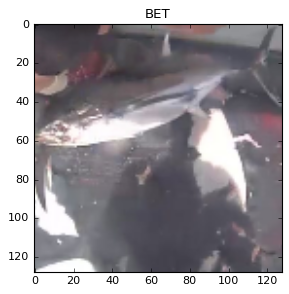

[(0.088349022, 'ALB'), (0.8646158, 'BET'), (0.00048160253, 'DOL'), (2.465071e-05, 'LAG'), (1.8920641e-11, 'SHARK'), (0.046528876, 'YFT')]


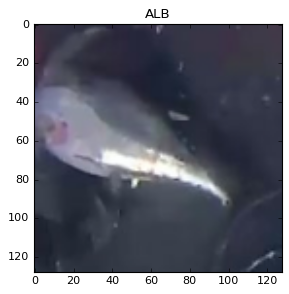

[(0.99797863, 'ALB'), (0.0018975157, 'BET'), (4.5618154e-09, 'DOL'), (1.1917769e-12, 'LAG'), (2.2266454e-06, 'SHARK'), (0.00012162244, 'YFT')]


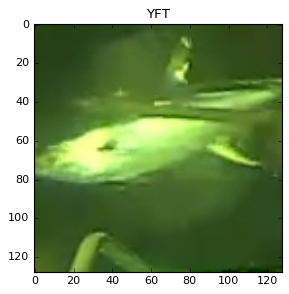

[(0.57612157, 'ALB'), (0.050092604, 'BET'), (0.00081931142, 'DOL'), (9.6369913e-05, 'LAG'), (0.00038698173, 'SHARK'), (0.37248307, 'YFT')]


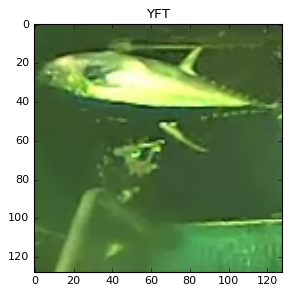

[(0.65522844, 'ALB'), (0.0012121281, 'BET'), (5.6977651e-06, 'DOL'), (1.5453983e-08, 'LAG'), (3.3447247e-07, 'SHARK'), (0.34355339, 'YFT')]


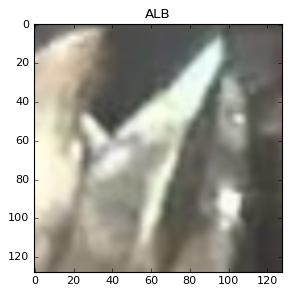

[(0.98715043, 'ALB'), (0.006535897, 'BET'), (0.00021188437, 'DOL'), (5.0831954e-06, 'LAG'), (5.2214266e-10, 'SHARK'), (0.0060966858, 'YFT')]


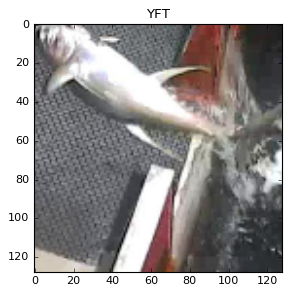

[(0.22199059, 'ALB'), (0.03955112, 'BET'), (0.0019281136, 'DOL'), (4.2243896e-06, 'LAG'), (1.3805017e-07, 'SHARK'), (0.73652583, 'YFT')]


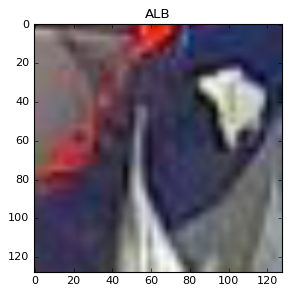

[(0.45104989, 'ALB'), (0.13486199, 'BET'), (9.0343492e-06, 'DOL'), (1.749467e-10, 'LAG'), (8.4122696e-08, 'SHARK'), (0.41407895, 'YFT')]


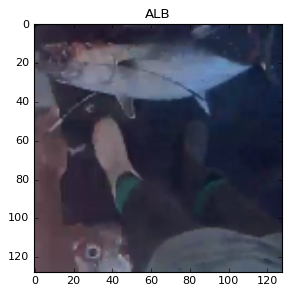

[(1.0, 'ALB'), (3.8188043e-11, 'BET'), (4.049953e-21, 'DOL'), (2.6526665e-33, 'LAG'), (4.2756416e-30, 'SHARK'), (9.2604556e-16, 'YFT')]


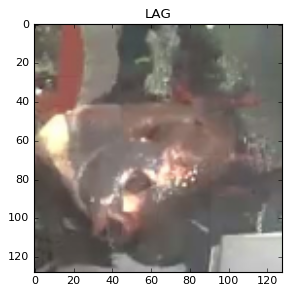

[(0.46799937, 'ALB'), (0.0061852643, 'BET'), (0.013182878, 'DOL'), (0.44015673, 'LAG'), (9.8929231e-10, 'SHARK'), (0.072475784, 'YFT')]


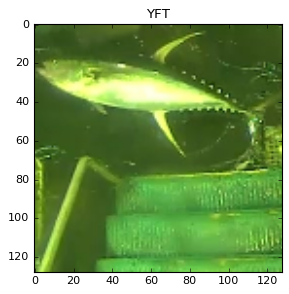

[(0.0061011808, 'ALB'), (4.2350359e-09, 'BET'), (8.6250681e-16, 'DOL'), (2.8028862e-23, 'LAG'), (1.3574311e-08, 'SHARK'), (0.99389875, 'YFT')]


In [36]:
for _ in range(10):
    show_random(best_model)